In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 6,249
training + validation N: 24,234


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,315,7,-0.587914,AGUGUGCAA
2,validation,27,0,-0.438475,UAAGCUUUU
3,training,130,2,-0.631467,AUGGUCGGG
4,training,552,19,-0.433012,AGGGCAGGA
5,training,151,184,1.094011,AAGGUCCGC
6,training,88,4,-0.241737,CAGGCAAAC
7,training,105,5,-0.238471,GUGGCAAAU
8,validation,14,0,-0.167408,CAUGCAGCU
9,training,170,14,-0.048222,CAAGUCACU


In [3]:
# Get sequence length
L = len(data_df['x'][0])

# Set filename
name = 'mpsa_ge_blackbox'

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='rna',
                     gpmap_type='blackbox',
                     gpmap_kwargs={
                         'hidden_layer_sizes':[10]*5,
                         'features':'pairwise'
                     },
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=1000,
          batch_size=50,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

# Save models
model.save(name)

N = 24,234 observations set as training data.
Using 24.8% for validation.
Data shuffled.
Time to set data: 0.571 sec.
Epoch 1/1000
365/365 [==============================] - 2s 5ms/step - loss: 71.4415 - I_var: -0.4555 - val_loss: 64.2741 - val_I_var: -0.3065
Epoch 2/1000
365/365 [==============================] - 1s 3ms/step - loss: 58.8987 - I_var: -0.1769 - val_loss: 53.7139 - val_I_var: -0.0510
Epoch 3/1000
365/365 [==============================] - 1s 3ms/step - loss: 49.9269 - I_var: 0.0508 - val_loss: 46.0371 - val_I_var: 0.1558
Epoch 4/1000
365/365 [==============================] - 1s 3ms/step - loss: 44.1358 - I_var: 0.2098 - val_loss: 42.8016 - val_I_var: 0.2452
Epoch 5/1000
365/365 [==============================] - 1s 3ms/step - loss: 40.8938 - I_var: 0.3016 - val_loss: 38.8178 - val_I_var: 0.3630
Epoch 6/1000
365/365 [==============================] - 1s 4ms/step - loss: 38.3295 - I_var: 0.3765 - val_loss: 38.1071 - val_I_var: 0.3809
Epoch 7/1000
365/365 [================

In [4]:
# Load model
model = mavenn.load(name)

Model loaded from these files:
	mpsa_ge_blackbox.pickle
	mpsa_ge_blackbox.h5


In [5]:
!du -k $name*

56	mpsa_ge_blackbox.h5
4	mpsa_ge_blackbox.pickle


In [6]:
# Get x and y
x = test_df['x']
y = test_df['y']

On test data:
I_var_test: 0.432 +- 0.024 bits
I_pred_test: 0.483 +- 0.013 bits


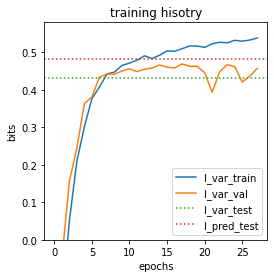

In [7]:
# Show training history
print('On test data:')

# Compute variational information
I_var, dI_var =  model.I_variational(x=x, y=y)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x, y=y)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

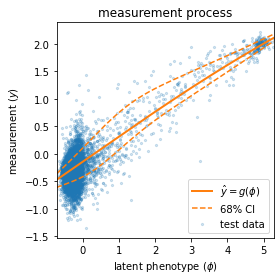

In [8]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [min(phi), max(phi)]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

In [9]:
# Test simulate_data
sim_df = model.simulate_dataset(N=1000)
sim_df.head()

,set,yhat,phi,y,x
0,training,-0.208139,-0.145679,-0.430888,GUCGUGGGC
1,training,-0.235294,-0.205056,-0.193998,UUGGCUGUC
2,test,-0.204244,-0.137164,0.360180,UCCGUACGG
3,training,2.001449,4.992811,1.960023,AAGGUAUUA
4,test,-0.328016,-0.407937,-0.212976,UACGCUCGU
